# Includes

In [28]:
import random
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import numpy as np
import copy
from SolarYield import *
from IPython.display import clear_output
import pandas as pd

# Initialisation des paramètres

In [29]:
Npop = 100
Narchive = 10
Sp = 2
alpha = 0.7
Gmax = 100
pmut = 1
Ntour = 10

nb_x = 12
nb_fonction = 3
nb_contrainte = 4

# 0 = NumOnd_1, 1 = Nps_1, 2 = Npp_1, 3 = gamma_1, 4 = i_1, 5 = nbinsta_1, 6 = NumOnd_2, 7 = Nps_2, 8 = Npp_2, 9 = gamma_2, 10 = i_2, 11 = nbinsta_2
VarDicr = [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]
ArDicr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] # arrondi des variables
xmax = [2, 30, 30, 90, 90, 50, 2, 30, 30, 90, 90, 50]
xmin = [1, 1, 1, -90, 0, 1, 1, 1, 1, -90, 0, 1]

NewPop = 1 # 1 = recommencer avec une nouvelle population aléatoire ou 0 charger la population précédente
generationPop = 1 # recommencer à la génération 0 ou charger la génération précédente

# Initialisation variables

In [30]:
# variables Opti
pop_anim = []

population = []
pop_admissible = []
archive = []
pareto = []

generation =[0]
Ninadmissible = np.zeros(Gmax + 1)
plotadmissible = []
plotinadmissible = []

gscale = []

first_eval = True

if NewPop == 0:
    generation[0] = generationPop

In [31]:
# Variables solaire
time = []
date = []
P_el_total = []
N = 20 # nombre d'années
Interet = 0.04 # taux d'intérêt
psi = Interet / (1.-(1.+Interet)**(-N))
BPE = 0.150
SPE = 0.050
L = 4.827 # longitude
phi = 50.947 # latitude
albedo = 0.2
Rserie = 1000 # résistance série
Rpara = 1 # résistance parallèle
NOCT = 48 # température normale de fonctionnement
I0 = 38*10**(-3) # courant d'éclairement en mA/cm²
G0 = 1000 # irradiation normale
TambOpti = 25 ############## Vmin = ????
Iobs = 1.5*10**(-12) # courant d'obscurité en A/cm²
coefId = 1.2 # coefficient d'idéalité de la diode
NbCellS = 72 # nombre de cellules en série dans un panneau
NbCellP = 1 # nombre de panneaux en parallèle
eVerre = 3 # épaisseur du verre en mm
PrixPV = 300 # prix d'un panneau en euros
UTC = np.arange(0,24,1) # temps universel coordonné

CaractOnduleur = np.zeros((3, 8))
CaractOnduleur[0, :] = [4.5, 9., 1000, 150., 800., 230., 3*6.5, 1213.] # Pacnom, Pdcmax, Vindc, VinMPPT min, Vin MPPT max, Vacout, Iacout, Prix
CaractOnduleur[1, :] = [25 , 37.8, 1000, 580., 850., 230., 3*39.1, 2594.] # Pacnom, Pdcmax, Vindc, VinMPPT min, Vin MPPT max, Vacout, Iacout, Prix
CaractOnduleur[2, :] = [60, 90., 1000, 570., 800., 230., 3*87., 3897.] # Pacnom, Pdcmax, Vindc, VinMPPT min, Vin MPPT max, Vacout, Iacout, Prix

Onduleurs = []
class Onduleur:
    def __init__(self, Pacnom, Pdcmax, Vindc, VinMPPTmin, VinMPPTmax, Vacout, Iacout, Prix):
        self.Pacnom = Pacnom
        self.Pdcmax = Pdcmax
        self.Vindc = Vindc
        self.VinMPPTmin = VinMPPTmin
        self.VinMPPTmax = VinMPPTmax
        self.Vacout = Vacout
        self.Iacout = Iacout
        self.Prix = Prix

# charger les données onduleurs dans Onduleurs
for i in range(0, len(CaractOnduleur)):
    Onduleurs.append(Onduleur(CaractOnduleur[i, 0], CaractOnduleur[i, 1], CaractOnduleur[i, 2], CaractOnduleur[i, 3], CaractOnduleur[i, 4], CaractOnduleur[i, 5], CaractOnduleur[i, 6], CaractOnduleur[i, 7]))

# qCO2Belgique = 0.318*378*10**-3 # kg/MWh
qCO2Belgique = 0.152 # kg/kWh sur la dernière année https://www.electricitymap.org/?page=country&solar=false&remote=true&wind=false&countryCode=BE 
qC02PV = 2000 # kg/kW



# Fonction Solaire

In [32]:
def EnergyBalance(time, date, P_dmd, P_nf):

    m = len(date) # the number of lines in P
    n = len(time) # the number of columns in P
    dt = 24. / n

    P_grid = np.zeros((m,n), dtype=float)      # the power imported from the grid
    P_export = np.zeros((m,n), dtype=float)    # the power exported to the grid
    
    E_grid = 0.
    E_export = 0.
    E_dmd = 0.

    for i in range(m):
        for j in range(n):
            P_export[i,j] = max(P_nf[i,j]-P_dmd[i,j], 0.) # Export excess energy to grid
            P_grid[i,j] = max(P_dmd[i,j]-P_nf[i,j], 0.) # Import required energy from grid

        E_grid += np.trapz(P_grid[i,:], time) 
        E_export += np.trapz(P_export[i,:], time)
        E_dmd += np.trapz(P_dmd[i,:], time)

    return E_grid, E_export, E_dmd

def GetPVProduction():
    Ghprim = [] # créer une liste vide pour stocker le rayonnement global
    Dhprim = [] # créer une liste vide pour stocker le rayonnement diffus
    Tambprim = [] # créer une liste vide pour stocker la température ambiante
    dpm = [31,28,31,30,31,30,31,31,30,31,30]
    PVGISData = open("DataOnshore_be.csv", 'r')
    Buf = PVGISData.readlines()
    n_lines = len(Buf)-17-12
    dt = 1.
    n_step = int(24. / dt)
    n_days = int(n_lines / n_step)
    date = np.arange(0,n_days)
    time = np.arange(0,24,dt)
    j = 0 # index for the time
    k = 0 # index for the day
    Epv = 0. # the energy produced by the PV
    # créer une liste à 2 dimensions pour stocker les données de G et D
    for i in range(n_lines):
        (Buf1, Buf2, Buf3, Buf4, Buf5, Buf6, Buf7, Buf8, Buf9, Buf10) = Buf[i+17].split(',')
        (tmp1, tmp2) = Buf1.split(':')
        yy = tmp1[0:4]
        mm = tmp1[4:6]
        dd = tmp1[6:8]
        h = tmp2[0:2]
        m = tmp2[2:4]
        t_float = float(h)
        j, = np.where(time==t_float)
        k = int(dd)-1+int(np.sum(dpm[0:int(mm)-1]))
        
        Ghprim = np.append(Ghprim, float(Buf4))
        Dhprim = np.append(Dhprim, float(Buf6))
        Tambprim = np.append(Tambprim, float(Buf2))

    Ghprim = np.reshape(Ghprim, (365,24)) # copier P_pv dans un tableau à 2 dimensions
    Dhprim = np.reshape(Dhprim, (365,24)) # copier P_pv dans un tableau à 2 dimensions
    Tambprim = np.reshape(Tambprim, (365,24)) # copier P_pv dans un tableau à 2 dimensions

    return time, date, Ghprim, Dhprim, Tambprim

def PvYield(gamma, i, Nps, Npp, NumOnd, nbinsta):
        P_pv = [] # créer une liste vide pour stocker la production PV
        Epv = 0. # the energy produced by the PV
        for d in range(365):                                                                     
            (a,hprim,TST, h_n, UTC_0, UTC_1) = SunPosition(d, UTC, L, phi)
            (Rs, Rd, theta) = IrradiationRatio(i, gamma, a, hprim, albedo, Gh[d,:], Dh[d,:])
            Gabs = GlassAbsorbtion((Gh[d,:]-Dh[d,:])*Rs, Dh[d,:]*Rd, theta, e=eVerre)
            (Pm, Vm) = PV_panel(Gabs, Tamb[d,:], NOCT = NOCT, Rs = Rpara, Rsh=Rserie, Id0 = Iobs, Iphi0 = I0, G0 = G0, n = coefId , ncs = NbCellS, ncp = NbCellP) # n = coef idealité // Eg = Energy gap (reste constant) et Rsh = resistance parallèle (reste constant)
            Ppv = PV_array(Pm, Vm, Nps, Npp, Onduleurs[int(NumOnd)].Pdcmax, Onduleurs[int(NumOnd)].VinMPPTmax, Onduleurs[int(NumOnd)].VinMPPTmin)*nbinsta # a0, a1, a2 les mêmes et tauloss = ??
            P_pv = np.append(P_pv, Ppv) # ajouter Ppv à P_pv
            Epv += np.trapz(Ppv,UTC)
        P_pv = np.reshape(P_pv, (365,24)) # copier P_pv dans un tableau à 2 dimensions
        return P_pv

def GetProfile():
    dpm = [0,31,28,31,30,31,30,31,31,30,31,30]
    # url = "https://raw.githubusercontent.com/Louis9551/Solaire/main/Groupe1.csv"  # Remplacez par l'URL de votre fichier
    # response = requests.get(url)
    # ConsoData = response.text
    ConsoData = open("Groupe1.csv", 'r')
    Buf = ConsoData.readlines()
    n_lines = len(Buf)
    dt = 1.
    n_step = int(24. / dt)
    n_days = 365
    E_house = np.zeros((n_days,n_step), dtype=float)
    date = np.arange(0,n_days)
    time = np.arange(0,24,dt)

    j = 0 # index for the time
    k = 0 # index for the day
    for i in range(n_lines-1):
        (tmp1, tmp2, Buf1) = Buf[i+1].split(',')
        (yy, mm, dd) = tmp1.split('-')
        (h, m, s) = tmp2.split(':')
        t_float = round(float(h)+float(m)/60.,0)
        j, = np.where(time==t_float)
        k = int(dd)-1+np.sum(dpm[0:int(mm)])
        E_house[k,j[0]] = float(Buf1)
    return time, date, E_house

def LoadDurationCurve(t, d, P, color='blue', name='Power', steps=250):
    m = len(d) # the number of lines in P
    n = len(t) # the number of columns in P
    dt = 24. / n
    
    Psteps = np.linspace(0., np.amax(P)*1.1, num=steps) # the power considered in the cumulative sum
    Tau = np.zeros(steps, dtype=float) # the number of operating hours
    Pflat = np.reshape(P, m*n)
    for i in range(steps, 0, -1): Tau[i-1] = (np.ma.masked_greater_equal(Pflat, Psteps[i-1])).mask.sum()*dt
    E_tot = 0
    for i in range(m): E_tot += np.trapz(P[i,:], t)
        
    P_max = np.amax(Pflat)
    tau_e = E_tot / P_max
    load_factor = tau_e / (m*24.)
    P_avg = P_max * load_factor

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.close(fig)
    ax.fill_between(Tau, Psteps, 0., facecolor=color, alpha=.5, interpolate=True, label=u'%s= %.0f MWh/y' %(name,E_tot/1000.))
    ax.set_xlim(0, m*24.)
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Power [kW]')
    ax.set_xlabel('Time [h/year]')
    ax.grid(True)
    ax.annotate(r'$P_{peak}$ = %.2f kW ($P_{avg}$ = %.2f kW)' %(P_max, P_avg), xy=(0, P_max), xytext=(tau_e/3, P_max),
            arrowprops=dict(facecolor='black', shrink=0.05))
    ax.text(tau_e, P_max/3*2, r'$\tau_e$ = %.0f h/y (load factor= %.2f)' %(tau_e, load_factor))
    ax.legend()
    return fig


# Création de la classe individu

In [33]:
class Individu:
    def __init__(self, x):
        self.x = x
        self.f = np.zeros(nb_fonction)
        self.g = np.zeros(nb_contrainte)
        self.rank = 0
        self.fviol = 0
    
    # 0 = NumOnd_1, 1 = Nps_1, 2 = Npp_1, 3 = gamma_1, 4 = i_1, 5 = nbinsta_1, 6 = NumOnd_2, 7 = Nps_2, 8 = Npp_2, 9 = gamma_2, 10 = i_2, 11 = nbinsta_2
    
    def evaluationObjectifs(self):
        P_pv = PvYield(self.x[3], self.x[4], self.x[1], self.x[2], self.x[0], self.x[5])
        P_pv += PvYield(self.x[9], self.x[10], self.x[7], self.x[8], self.x[6], self.x[11])
        (E_grid, E_export, Edmd) = EnergyBalance(time, date, P_el_total, P_pv) # Energy en kWh
        c0 = self.x[1]*self.x[2]*PrixPV*self.x[5] + Onduleurs[int(self.x[0])].Prix*self.x[5] + self.x[7]*self.x[8]*PrixPV*self.x[11] + Onduleurs[int(self.x[6])].Prix*self.x[11]
        (Pmax, Vmin) = PV_panel([G0], [TambOpti], NOCT = NOCT, Rs = Rpara, Rsh=Rserie, Id0 = Iobs, Iphi0 = I0, G0 = G0, n = coefId , ncs = NbCellS, ncp = NbCellP)  # Pmax en W et Vmin en V
        Ppv_rated = Pmax*self.x[1]*self.x[2]*self.x[5]*10**-3 # en kW
        Ppv_rated += Pmax*self.x[7]*self.x[8]*self.x[11]*10**-3 # en kW

        self.f[0] = (c0*psi+(BPE*E_grid-SPE*E_export))/(Edmd) # cout sur 20 ans en euros/kWh
        self.f[1] = (Ppv_rated*qC02PV+qCO2Belgique*E_grid*20)/(Edmd*20) # émission sur 20 ans en kgCO2/kWh

        d_psi = (Interet/((Edmd*BPE-BPE*E_grid+SPE*E_export)/c0))

        if  d_psi < 1:
            self.f[2] = -(math.log(1-d_psi))/math.log(1+Interet) # Discounted Pay-Back Period (DPBP)
        else:
            self.f[2] = 1000

    def evaluationContraintes(self):
        self.g[0] = 0.152 - self.f[1]
        self.g[1] = 0.150 - self.f[0]
        self.g[2] = self.f[1]
        self.g[3] = self.f[0]
        #self.g[4] = 10 - self.f[2]
        

    def evaluationFacteurViol(self):
        for i in range(0, len(self.g)):
            if(self.g[i] > 0):
                self.g[i] = 0
            self.fviol += self.g[i] * gscale[i]
            
    def modif_rank(self, rank):
        self.rank = rank

# Création des fonctions Multi-Objectif

In [34]:
# Affichage de la population
def plot_population(plotadmissible, plotinadmissible):
    plt.figure()
    plt.plot([individu.f[0] for individu in plotadmissible], [individu.f[1] for individu in plotadmissible], 'ro', markersize=1, label='Admissible' )
    plt.plot([individu.f[0] for individu in plotinadmissible], [individu.f[1] for individu in plotinadmissible], 'bo', markersize=1, label='Inadmissible' )
    plt.ylabel('Intensité carbone (kgCO2/kWh)')
    plt.xlabel('LCOE (€/kWh)')
    plt.title('Population')
    plt.grid(True)
    plt.show()

def plot_admissible(plotadmissible):
    plt.figure()
    plt.plot([individu.f[0] for individu in plotadmissible], [individu.f[1] for individu in plotadmissible], 'ro', markersize=1 )
    plt.hlines(qCO2Belgique, 0, BPE, colors='k', linestyles='solid') 
    plt.vlines(BPE, 0, qCO2Belgique, colors='k', linestyles='solid') 
    plt.ylabel('Intensité carbone (kgCO2/kWh)')
    plt.xlabel('LCOE (€/kWh)')
    plt.title('Population admissible')
    plt.grid(True)
    plt.show()

def plot_inadmissible(Ninadmissible, generation):
    plt.figure()
    plt.plot(generation, Ninadmissible, 'r')
    plt.ylabel('Nombre d\'individus inadmissibles')
    plt.xlabel('Génération')
    plt.xlim(0, Gmax)
    plt.ylim(0, Npop+1)
    plt.title('Evolution du nombre d\'individus inadmissibles')
    plt.grid(True)
    plt.show()

def scale(population):
    sumgmin = 0

    for i in range(0, nb_contrainte):
        gscale.append(population[0].g[i])

    for i in range(0, nb_contrainte):
        for individu in population:
            if individu.g[i] < gscale[i]:
                gscale[i] = abs(individu.g[i])
        sumgmin += gscale[i]

    if sumgmin != 0:
        for i in range(0, nb_contrainte):
            gscale[i] = gscale[i]/sumgmin

        if nb_contrainte > 1:
            for i in range(0, nb_contrainte):
                gscale[i] = 1 - gscale[i]
    else:
        for i in range(0, nb_contrainte):
            gscale[i] = 1 

def ranking(population, archive):
    for i in pop_admissible:
        for j in pop_admissible:
            if i!=j: # ne compare pas avec le individu hors contrainte
                if population[j].f[0] <= population[i].f[0] and population[j].f[1] <= population[i].f[1]:
                    population[i].rank += 1

        if population[i].rank == 0 and population[i].fviol == 0:
            archive.append(copy.deepcopy(population[i]))

def archivage(archive, Narchive):
    temp = []
    for i in archive:
        i.modif_rank(0)
        for j in archive:
            if i!=j:
                if j.f[0] <= i.f[0] and j.f[1] <= i.f[1]:
                    i.rank += 1
                    break
        if i.rank == 0:
            temp.append(i)

    archive.clear()
    N = Narchive
    if len(temp) < N:
        N = len(temp)

    for i in range(N):
        archive.append(random.choice(temp))

def plot_pareto(population, Npop):
    for i in range(Npop):
        if population[i].rank == 0 and population[i].fviol == 0:
            pareto.append(copy.deepcopy(population[i]))

    # Plot points from the Pareto front
    plt.scatter([individu.f[0] for individu in pareto], [individu.f[1] for individu in pareto], cmap='viridis', vmin=5, vmax=15, c=[individu.f[2] for individu in pareto] , label='Dernière génération')
    plt.plot([individu.f[0] for individu in archive], [individu.f[1] for individu in archive], 'ro', markerfacecolor = 'none', label='Archive')

    # Set labels and title
    plt.ylabel('Intensité carbone (kgCO2/kWh)')
    plt.xlabel('LCOE (€/kWh)')
    plt.title('Front de Pareto')

    # show grid
    plt.grid(True)

    #show limit
    #plt.hlines(qCO2Belgique, 0, BPE, colors='k', linestyles='solid') 
    #plt.vlines(BPE, 0, qCO2Belgique, colors='k', linestyles='solid') 

    # Show legend
    plt.legend()
    plt.colorbar(label='DPBP (année)')

    # Display the plot
    plt.show()

# Initialisation de la population
def initialisation(population, Npop, NewPop, generation): #si NewPop = True alors on crée une nouvelle population
    
    if NewPop:
        for i in range(Npop):
            x = np.zeros(nb_x) 
            for j in range(nb_x):
                x[j] = random.uniform(xmin[j], xmax[j])
                if VarDicr[j]:                  # si la variable est discrète
                    x[j] = round(x[j],ArDicr[j])      # on arrondi
            population.append(Individu(x))
    else: #charger la population depuis un fichier csv
        with open(f'population_{generation[0]}.csv', 'r') as f:
            for line in f:
                x = np.zeros(nb_x) 
                indiv = [float(val) for val in line.strip().split(';')]
                for i in range(nb_x):
                    x[i] = int(indiv[i])
                population.append(Individu(x))

def evaluation(population):
    for individu in population:
        individu.evaluationObjectifs()
        individu.evaluationContraintes()
        clear_output()
        print("generation :",generation[-1])
        print("individu :",population.index(individu)+1,"/",len(population))

    if first_eval:
        scale(population)
    
    pop_admissible.clear()
    i=0
    for individu in population:
        individu.evaluationFacteurViol()
        
        if individu.fviol == 0:
            plotadmissible.append(copy.deepcopy(population[i]))
            pop_admissible.append(i)
        else:
            plotinadmissible.append(copy.deepcopy(population[i]))
            if NewPop == 0:
                Ninadmissible[generation[-1]-generationPop] += 1
            else:
                Ninadmissible[generation[-1]] += 1
        i += 1

# Sélection des parents
def selection_tournoi(population, Ntour):
    new_population = []
    for i in range(Npop):
        best = []
        for j in range(Ntour):
            individu = random.choice(population)
            if len(best) == 0:
                best.clear()
                best.append(individu)
            elif individu.fviol > best[0].fviol :
                best.clear()
                best.append(individu)
            elif individu.rank < best[0].rank:
                best.clear()
                best.append(individu)
            else:
                best.append(individu)
        new_population.append(random.choice(best))
    population.clear()
    for individu in new_population:
        population.append(individu)


# Croisement
def croisement(population, Npop):
    new_population = []
    while len(new_population) < Npop :
         # Tirer au hasard deux individus
        parent1 = random.choice(population)
        population.remove(parent1)
        parent2 = random.choice(population)
        population.remove(parent2)

        # calcul de lambda
        u = random.uniform(0,1)
        Y = u*(1+2*alpha)-alpha

        x = np.zeros((2,nb_x))
        for i in range(nb_x):
            if VarDicr[i]:    
                # Calcul des enfants
                x[0][i] = round(Y*parent1.x[i] + (1-Y)*parent2.x[i],ArDicr[i])
                x[1][i] = round((1-Y)*parent1.x[i] + Y*parent2.x[i],ArDicr[i])
            else:
                x[0][i] = Y*parent1.x[i] + (1-Y)*parent2.x[i]
                x[1][i] = (1-Y)*parent1.x[i] + Y*parent2.x[i]
        # Vérification des bornes
        for i in range(2):
            ok = True
            for j in range(nb_x):
                if x[i][j] > xmax[j] or x[i][j] < xmin[j]:
                    ok = False
            if ok:
                new_population.append(Individu(x[i]))
            else:
                if random.choice([True, False]):
                    new_population.append(parent1)
                else:
                    new_population.append(parent2)

    population.clear()
    for individu in new_population:
         population.append(individu)

# Mutation
def mutation(population, pmut, generation, xmax, xmin, Gmax):
    for individu in population:
        if random.uniform(0,100) < pmut:
            xi = random.choice([0,nb_x-1]) # on ne random pas le NumOnd
            delta = random.choice([-1,1])
            if delta == 1:
                pas = random.uniform(0,1)*(xmax[xi]-individu.x[xi])*(1-generation[-1]/(Gmax+generation[0]))
            else:
                pas = random.uniform(0,1)*(individu.x[xi]-xmin[xi])*(1-generation[-1]/(Gmax+generation[0]))
            if(VarDicr[xi]):
                individu.x[xi] = round(individu.x[xi] + delta*pas, ArDicr[xi]) # on arrondi si la variable est discrète
                if(xi == 0): # si NumOnd alors rester dans les bornes
                    if(individu.x[xi] > xmax[xi]):
                        individu.x[xi] = xmax[xi]
                    elif(individu.x[xi] < xmin[xi]):
                        individu.x[xi] = xmin[xi]
            else:
                individu.x[xi] = individu.x[xi] + delta*pas

# sauvegarder population dans un fichier csv
def save_population(population, generation):
    with open(f'population_{generation[-1]}.csv', 'w') as f:
        for individu in population:
            # Modification pour un vecteur de dimension 5
            x_values = ';'.join(map(str, individu.x))
            f_values = ';'.join(map(str, individu.f))
            f.write(f'{x_values};{f_values}\n')

# Programme principal

c:\Users\ciold\OneDrive - student.helmo.be\#GRAMME\M2\ENERGIE_SOLAIRE\PROJET\Loic - V4 - 2 groupe - 100 pop - 100 gen\SolarYield.py:89: RuntimeWarning: invalid value encountered in divide
  Rd = np.where( Dh != 0., (1.+np.cos(np.radians(i)))/2. + (1.-np.cos(np.radians(i)))/2. * albedo * np.divide(Gh,Dh), 0.)
c:\Users\ciold\OneDrive - student.helmo.be\#GRAMME\M2\ENERGIE_SOLAIRE\PROJET\Loic - V4 - 2 groupe - 100 pop - 100 gen\SolarYield.py:124: RuntimeWarning: divide by zero encountered in divide
  eta_inv = np.where(P_in_dc > 0, 1. - a0 - a1*np.divide(Prated,P_in_dc) - a2*np.divide(P_in_dc,Prated), 0.)
c:\Users\ciold\OneDrive - student.helmo.be\#GRAMME\M2\ENERGIE_SOLAIRE\PROJET\Loic - V4 - 2 groupe - 100 pop - 100 gen\SolarYield.py:89: RuntimeWarning: divide by zero encountered in divide
  Rd = np.where( Dh != 0., (1.+np.cos(np.radians(i)))/2. + (1.-np.cos(np.radians(i)))/2. * albedo * np.divide(Gh,Dh), 0.)


KeyboardInterrupt: 

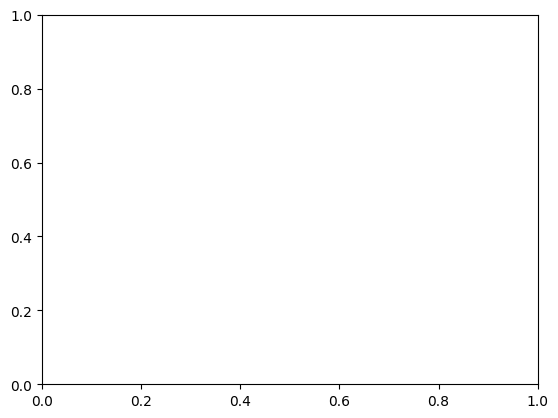

In [35]:
fig, ax = plt.subplots()

# Charger les données de consommation
(time, date, P_el_total) = GetProfile()
(time, date, Gh, Dh, Tamb) = GetPVProduction()

# Initialisation de la population
initialisation(population, Npop, NewPop, generation)
#pop_anim.append(population.copy())

# # afficher la population initiale
# for individu in population:
#     print(individu.x, individu.f)

# Evaluation de la population
evaluation(population)
    
first_eval = False
ranking(population, archive)

# Boucle principale

for i in range(Gmax):
    # Incrémentation du nombre de génération
    generation.append(generation[-1] + 1)

    # Sélection des parents
    selection_tournoi(population, Ntour)

    # Croisement
    croisement(population, Npop)

    # Mutation
    mutation(population, pmut, generation, xmax, xmin, Gmax)

    #pop_anim.append(population.copy())

    # Evaluation de la population
    evaluation(population)
    ranking(population, archive)
    archivage(archive, Narchive)

save_population(population, generation)

plot_pareto(population, Npop)
plot_inadmissible(Ninadmissible, generation)
plot_population(plotadmissible, plotinadmissible)

## Afficher la production d'un individu

In [ ]:
NumIndividu = 0
P_PV_Ind = PvYield(pareto[NumIndividu].x[3], pareto[NumIndividu].x[4], pareto[NumIndividu].x[1], pareto[NumIndividu].x[2], pareto[NumIndividu].x[0], pareto[NumIndividu].x[5])
P_PV_Ind += PvYield(pareto[NumIndividu].x[9], pareto[NumIndividu].x[10], pareto[NumIndividu].x[7], pareto[NumIndividu].x[8], pareto[NumIndividu].x[6], pareto[NumIndividu].x[11])
LDC_PV = LoadDurationCurve(time, date, P_PV_Ind, color='green', name='PV production', steps=250)
display(LDC_PV)
LDC_elec = LoadDurationCurve(time, date, P_el_total, color='blue', name='Electricity Demand', steps=250)
display(LDC_elec)

IndexError: list index out of range

In [ ]:
# Initialize an empty DataFrame
df = pd.DataFrame(columns=['NumOnd_1', 'Nps_1', 'Npp_1', 'gamma_1', 'i_1', 'Ninsta_1', 'NumOnd_2', 'Nps_2', 'Npp_2', 'gamma_2', 'i_2', 'Ninsta_2', 'f1', 'f2', 'f3'])

# Create a list to hold dictionaries for each individual in pareto
data_list = []

for ind in pareto:
    data_list.append({
        'NumOnd_1': ind.x[0],  # Replace with the actual property name for index 0
        'Nps_1': ind.x[1],     # Replace with the actual property name for index 1
        'Npp_1': ind.x[2],     # Replace with the actual property name for index 2
        'gamma_1': ind.x[3],   # Replace with the actual property name for index 3
        'i_1': ind.x[4],       # Replace with the actual property name for index 4
        'Ninsta_1': ind.x[5],  # Replace with the actual property name for index 5
        'NumOnd_2': ind.x[6],  # Replace with the actual property name for index 5
        'Nps_2': ind.x[7],     # Replace with the actual property name for index 6
        'Npp_2': ind.x[8],     # Replace with the actual property name for index 7
        'gamma_2': ind.x[9],   # Replace with the actual property name for index 8
        'i_2': ind.x[10],      # Replace with the actual property name for index 9
        'Ninsta_2': ind.x[11], # Replace with the actual property name for index 10
        'f1': ind.f[0],
        'f2': ind.f[1],
        'f3': ind.f[2]   
    })

# Concatenate the list of dictionaries into the DataFrame
df = pd.concat([df, pd.DataFrame(data_list)], ignore_index=True)

# Print the resulting DataFrame
print(df)

Empty DataFrame
Columns: [NumOnd_1, Nps_1, Npp_1, gamma_1, i_1, Ninsta_1, NumOnd_2, Nps_2, Npp_2, gamma_2, i_2, Ninsta_2, f1, f2, f3]
Index: []


# Test

In [ ]:
# plt.figure()
# plt.plot([individu.f[0] for individu in plotadmissible], [individu.f[1] for individu in plotadmissible], 'ro', markersize=1 )
# plt.ylabel('f2')
# plt.xlabel('f1')
# plt.title('Population admissible')
# plt.grid(True)
# plt.xlim(0, 1)
# plt.ylim(0, 10)
# plt.show()

In [ ]:
# # 0 = NumOnd, 1 = Nps, 2 = Npp, 3 = gamma, 4 = i
# (time, date, P_el_total) = GetProfile()
# (time, date, Gh, Dh, Tamb) = GetPVProduction()
# individu = Individu([2, 20, 20, 90, 45])
# P_pv = PvYield(individu.x[3], individu.x[4], individu.x[1], individu.x[2], individu.x[0])
# (E_grid, E_export, Edmd) = EnergyBalance(time, date, P_el_total, P_pv)
# c0 = individu.x[1]*individu.x[2]*PrixPV + Onduleurs[int(individu.x[0])].Prix
# (Pmax, Vmin) = PV_panel([G0], [Vmin0])
# Ppv_rated = Pmax*individu.x[1]*individu.x[2]*1e-3
# individu.f[0] = c0*psi+(BPE*E_grid-SPE*E_export)*20 # att sur 20 ans
# individu.f[1] = (Ppv_rated*qC02PV+qCO2Belgique*E_grid*20)/Edmd # att sur 20 ans
# print(individu.x, individu.f)

In [ ]:
# def save_population(plotadmissible):
#     with open(f'population_admissible_100.csv', 'w') as f:
#         for individu in plotadmissible:
#             # Modification pour un vecteur de dimension 5
#             x_values = ';'.join(map(str, individu.x))
#             f_values = ';'.join(map(str, individu.f))
#             f.write(f'{x_values};{f_values}\n')

In [ ]:
ind = plotadmissible[0]

P_pv = PvYield(ind.x[3], ind.x[4], ind.x[1], ind.x[2], ind.x[0], ind.x[5])
P_pv += PvYield(ind.x[9], ind.x[10], ind.x[7], ind.x[8], ind.x[6], ind.x[11])
(E_grid, E_export, Edmd) = EnergyBalance(time, date, P_el_total, P_pv) # Energy en kWh
c0 = ind.x[1]*ind.x[2]*ind.x[5]*PrixPV + Onduleurs[int(ind.x[0])].Prix*ind.x[5] + ind.x[7]*ind.x[8]*ind.x[11]*PrixPV + Onduleurs[int(ind.x[6])].Prix*ind.x[11]
(Pmax, Vmin) = PV_panel([G0], [TambOpti])  # Pmax en W et Vmin en V
Ppv_rated = Pmax*ind.x[1]*ind.x[2]*ind.x[5]*10**-3 # en kW
Ppv_rated += Pmax*ind.x[7]*ind.x[8]*ind.x[11]*10**-3 # en kW

ind.f[0] = (c0*psi+(BPE*E_grid-SPE*E_export))/(Edmd) # cout sur 20 ans en euros/kWh
ind.f[1] = (Ppv_rated*qC02PV+qCO2Belgique*E_grid*20)/(Edmd*20) # émission sur 20 ans en kgCO2/kWh

d_psi = (Interet/((Edmd*BPE-BPE*E_grid+SPE*E_export)/c0))

if  d_psi < 1:
    ind.f[2] = -(math.log(1-d_psi))/math.log(1+Interet) # Discounted Pay-Back Period (DPBP)
else:
    ind.f[2] = -1

print('C0 =', c0*psi)
print('E_grid =', E_grid)
print('E_export =', E_export)
print('Edmd =', Edmd)
print('Ppv_rated =', Ppv_rated)
print('f1 =', ind.f[0])
print('f2 =', ind.f[1])
print('f3 =', ind.f[2])
print('d_psi =', d_psi)
print('gain =', (Edmd*BPE-BPE*E_grid+SPE*E_export))



d:\Utilisateurs\Louis\OneDrive - student.helmo.be\GRAMME\M2\Energie solaire\Projet\SolarYield.py:89: RuntimeWarning: invalid value encountered in divide
  Rd = np.where( Dh != 0., (1.+np.cos(np.radians(i)))/2. + (1.-np.cos(np.radians(i)))/2. * albedo * np.divide(Gh,Dh), 0.)
d:\Utilisateurs\Louis\OneDrive - student.helmo.be\GRAMME\M2\Energie solaire\Projet\SolarYield.py:124: RuntimeWarning: divide by zero encountered in divide
  eta_inv = np.where(P_in_dc > 0, 1. - a0 - a1*np.divide(Prated,P_in_dc) - a2*np.divide(P_in_dc,Prated), 0.)
d:\Utilisateurs\Louis\OneDrive - student.helmo.be\GRAMME\M2\Energie solaire\Projet\SolarYield.py:89: RuntimeWarning: divide by zero encountered in divide
  Rd = np.where( Dh != 0., (1.+np.cos(np.radians(i)))/2. + (1.-np.cos(np.radians(i)))/2. * albedo * np.divide(Gh,Dh), 0.)


C0 = 45259.104482635004
E_grid = 1796142.4395647626
E_export = 12283.307806411372
Edmd = 2185139.3498001876
Ppv_rated = [423.39450848]
f1 = 0.14119869130650953
f2 = 0.144317158395856
f3 = 12.250143439284072
d_psi = 0.38150078844419655
gain = 64491.19043851945
